In [1]:
import warnings
warnings.filterwarnings("ignore")
#
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain, combinations, product
from sklearn.model_selection import cross_val_predict
from networkx.algorithms.components import connected_components as connected_components
from nilearn.plotting import plot_connectome
import random
import os
#
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
SEED = 2021
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DATA_FOLDER = 'data/'
PLOT_FOLDER = 'plots/'
RERUN_EXPERIMENT = False #if False, logged results will be loaded

In [4]:
NUM_ELECTRODES = 116
EXP_NAME = 'eyesclosed'

In [5]:
def mine_motifs(graphs,ms,NUM_ELECTRODES):
    arcs_cube = np.zeros((len(graphs),NUM_ELECTRODES,NUM_ELECTRODES),dtype=int)
    for indxg,g in enumerate(graphs):
        for (n1,n2) in g.edges:
            arcs_cube[indxg,int(n1),int(n2)]=1
            arcs_cube[indxg,int(n2),int(n1)]=1
    arcs = [x for x in np.array(np.nonzero(np.sum(arcs_cube,axis=0)>=ms)).T if x[0]<x[1]]
    arcs_in = {n:[] for n in range(NUM_ELECTRODES)}
    arcs_out = {n:[] for n in range(NUM_ELECTRODES)}
    for s,t in arcs:
        if arcs_cube[:,s,t].sum() >= ms:
            arcs_in[t].append(int(s))
            arcs_out[s].append(int(t))
    twoplets_dict = {}
    
    def one_hop(edges):
        for n1, n2 in edges:
            for n3 in arcs_out[n1]:
                if (n1,n3) not in edges:
                    yield (n1,n2),(n1, n3)
            for n3 in arcs_in[n1]:
                if (n3,n1) not in edges:
                    yield (n1,n2),(n3,n1)
            for n3 in arcs_out[n2]:
                if (n2,n3) not in edges:
                    yield (n1,n2),(n2,n3)
            for n3 in arcs_in[n2]:
                if (n3,n2) not in edges:
                    yield (n1,n2),(n3,n2)
    
    for n1 in range(NUM_ELECTRODES):
        for n2 in arcs_out[n1]:
            for _, (n3, n4) in one_hop(set([(n1, n2)])):
                intersection = arcs_cube[:,n1,n2]&arcs_cube[:,n3,n4]
                if intersection.sum()>=ms:
                    new_key = frozenset([(n1,n2),(n3,n4)])
                    twoplets_dict[new_key]=intersection   
    results = {**twoplets_dict}
    new_stuff = twoplets_dict
    while True:
        old_stuff = new_stuff
        new_stuff = {}
        for m1 in old_stuff:
            for m2 in one_hop(m1):
                m2 = frozenset(m2)
                if m2 not in twoplets_dict:
                    continue
                new_key = frozenset(m1.union(m2))
                if new_key not in new_stuff:
                    intersection = old_stuff[m1]&twoplets_dict[m2]
                    if intersection.sum()>=ms: 
                        new_stuff[new_key]=intersection 
                        results[new_key]=intersection 
        if len(new_stuff)==0:
            break      
    return results

In [6]:
def cross_support(motif):
    (edges,occurrences) = motif
    sup_td = sum(occurrences[:ct])
    sup_asd = sum(occurrences[ct:])
    return abs(np.log2((sup_td+1)/(sup_asd+1)))

def jac_dist_fx(el1,el2):
    inters = len(set(el1).intersection(set(el2)))
    un = len(set(el1).union(set(el2)))
    return 1-inters/un

def select_motifs(all_motifs,num_motifs,min_dist):
    selected = [all_motifs[0][0]]
    indx = 1
    while len(selected)<num_motifs:
        cand = all_motifs[indx][0]
        if min([jac_dist_fx(m,cand) for m in selected])>=min_dist:
            selected.append(cand)
        indx+=1
    return selected

In [7]:
def edgelist_to_nx(edgelists):
    motifs = []
    for edgelist in edgelists:
        tmp = nx.empty_graph()
        for (n1,n2) in edgelist:
            tmp.add_edge(n1,n2)
        motifs.append(tmp)
    return motifs

In [8]:
def make_brain_dataset():
    td = pickle.load(open(DATA_FOLDER+EXP_NAME+'_td','rb'))
    asd = pickle.load(open(DATA_FOLDER+EXP_NAME+'_asd','rb'))
    graphs = td+asd
    labels = np.array([0.]*len(td)+[1.]*len(asd))
    idxs = np.arange(len(graphs))
    np.random.shuffle(idxs)
    max_train = int(len(graphs)*.75)
    idxs_trn = idxs[:max_train]
    idxs_tst = idxs[max_train:]
    xgraph_trn = [graphs[i] for i in idxs_trn]
    xgraph_tst = [graphs[i] for i in idxs_tst]
    label_trn = labels[idxs_trn].astype(int)
    label_tst = labels[idxs_tst].astype(int)
    return xgraph_trn,xgraph_tst,label_trn,label_tst

In [9]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

def pascaline(n):
    "pascaline(5) -> [1, 4, 6, 4, 1]"
    n -= 1
    line = [1]
    for k in range(max(n,0)):             
        line.append(line[k]*(n-k)//(k+1))             
    return line

def get_marginal(lattice,binary_code,position):
    key_nope = tuple((*binary_code[:position],0,*binary_code[position:]))
    key_with = tuple((*binary_code[:position],1,*binary_code[position:]))
    return lattice[key_nope]-lattice[key_with]

In [10]:
def normalise_adjm(adjm):
    adjm = np.array(adjm)
    n_batch, n_row, n_col = adjm.shape
    adjm = tf.add(np.eye(n_row).astype(np.float32),adjm)
    weights_row = tf.tensordot(adjm,tf.ones(n_col),axes=1)
    weights_col = tf.tensordot(tf.transpose(adjm,perm=[0,2,1]),tf.ones(n_row),axes=1)
    diag_row = tf.math.divide_no_nan(1.,tf.pow(weights_row, 0.5))
    diag_col = tf.math.divide_no_nan(1.,tf.pow(weights_col, 0.5))
    tmp = tf.multiply(adjm,tf.expand_dims(diag_col,axis=1))
    Anorm = tf.multiply(tf.expand_dims(diag_row,axis=2),tmp)
    return Anorm

class GConvNodeID(tf.keras.layers.Layer):
    def __init__(self,num_feat,num_out,activation):#W has shape (nodes,1)
        super(GConvNodeID,self).__init__()
        self.W = tf.Variable(tf.keras.initializers.GlorotUniform(seed=None)(shape=(num_feat,num_out)))
        self.activation = activation
    def call(self,A,X):
        XW = tf.einsum('bij,jk->bik',X,self.W)
        AXW = tf.einsum('bij,bjk->bik',A,XW)
        return self.activation(AXW)

In [11]:
def param_get_gconvnet(nodes_per_graph,dr1=.45,dr2=.45,num_neurons=32,activ='tanh',lr=.0001,loss='mse'):
    attr_input = tf.keras.Input(shape=(nodes_per_graph,nodes_per_graph))
    adjm_input = tf.keras.Input(shape=(nodes_per_graph,nodes_per_graph))
    activ = tf.nn.relu if activ=='relu' else tf.nn.tanh if activ=='tanh' else None
    #
    drop1 = tf.keras.layers.Dropout(dr1)(attr_input)
    gc1 = GConvNodeID(nodes_per_graph,num_neurons, activation=activ)(adjm_input,drop1)
    drop2 = tf.keras.layers.Dropout(dr1)(gc1)
    gc2 = GConvNodeID(num_neurons,num_neurons, activation=activ)(adjm_input,drop2)
    drop3 = tf.keras.layers.Dropout(dr1)(gc2)
    gc3 = GConvNodeID(num_neurons,num_neurons, activation=activ)(adjm_input,drop3)
    conc = tf.concat([gc1,gc2,gc3], axis=-1)
    conv1d =  tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=5, strides=1)(conc)
    flat = tf.keras.layers.Flatten()(conv1d)
    dense1 = tf.keras.layers.Dense(units=128, activation=activ)(flat)
    dropf = tf.keras.layers.Dropout(dr2)(dense1)
    dense2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(dropf)
    #
    gcnv = tf.keras.Model(inputs=[attr_input,adjm_input], outputs=dense2)
    gcnv.compile(optimizer=Adam(lr=lr), loss=loss)
    #
    return gcnv

In [12]:
def occurs_adjm(graph_adjm,edge_motif):
    return int((np.array([graph_adjm[x,y] for (x,y) in edge_motif])).all())

def mask_binary_toggle_edgelist(graph_adjm,edge_motifs,motifs_to_mask,occurring):
    adjm_clone = np.copy(graph_adjm)
    to_remove = [(em,tm,oc) for (em,tm,oc) in zip(edge_motifs,motifs_to_mask,occurring) if tm==1 and oc==1]
    for (edgex,edgey) in [a for b in [x[0] for x in to_remove] for a in b]:
        adjm_clone[edgex,edgey] = 0
        adjm_clone[edgey,edgex] = 0
    to_add = [(em,tm,oc) for (em,tm,oc) in zip(edge_motifs,motifs_to_mask,occurring) if tm==1 and oc==0]
    for (edgex,edgey) in [a for b in [x[0] for x in to_add] for a in b]:
        adjm_clone[edgex,edgey] = 1
        adjm_clone[edgey,edgex] = 1
    return adjm_clone

In [13]:
def get_batch_lattice(model,dummy_attr,graph_dataset,motifs):
    edge_motifs = [list(m.edges) for m in motifs]
    occurring = [[occurs_adjm(g,em) for em in edge_motifs] for g in graph_dataset]
    lattice_nodes = {}
    for motifs_to_mask in product([0, 1], repeat=len(motifs)):#FIX - minus one??
        masked_adjms = [mask_binary_toggle_edgelist(g,edge_motifs,motifs_to_mask,occ) \
                        for g,occ in zip(graph_dataset,occurring)]
        masked_datapoints = normalise_adjm(np.array(masked_adjms))
        scores = model.predict([dummy_attr,np.array(masked_datapoints)]).T[0]
        lattice_nodes[motifs_to_mask] = scores
    return lattice_nodes

def get_batch_shaps(lattice):
    num_motifs = len(list(lattice.keys())[0])
    num_graphs = len(list(lattice.values())[0])
    pascal = pascaline(num_motifs)
    edge_iterator = list(product([0, 1], repeat=num_motifs-1))
    num_edges = len(edge_iterator)
    depths = [min(sum(x),num_motifs-1-sum(x)) for x in edge_iterator]
    coef = [1./num_motifs/pascal[sum(code)] for code in edge_iterator]
    shap_tensor = np.zeros((num_edges,num_motifs,num_graphs))
    for motif_index in range(num_motifs):
        for edge_index,edge in enumerate(edge_iterator):
            shap_tensor[edge_index,motif_index,:] = get_marginal(lattice,edge,motif_index)
    return depths,coef,shap_tensor

In [14]:
def get_external_edges(num_motifs):
    zeros = [[0]*num_motifs for _ in range(num_motifs+1)]
    ones = [[1]*num_motifs for _ in range(num_motifs+1)]
    for i in range(num_motifs):
        zeros[i][i]=1
        ones[i][i]=0
    return [tuple(x) for x in zeros+ones]

In [15]:
def plot_graphshap_scores(local_shaps,motif_type,is_local=True):
    plt.figure(figsize=(8,4))
    plt.rcdefaults()
    m_names,lshap_vals = np.array(sorted(local_shaps.items(),key=lambda x:abs(x[1]),reverse=True)).T
    y_pos = np.arange(len(m_names))
    m_names = [motif_type+str(int(i)) for i in m_names]
    #
    if is_local:
        colors = ['orangered' if v<0 else 'dodgerblue' for v in lshap_vals]
    else:
        colors = ['limegreen' for v in lshap_vals]
    plt.bar(y_pos, lshap_vals, align='center', alpha=0.5, color=colors)
    #
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines["bottom"].set_position(("data", 0))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    label_offset = 0.005
    for m_name, (x_position, y_position) in zip(m_names, enumerate(lshap_vals)):
        if y_position > 0:
            label_y = -label_offset
        else:
            label_y = 2*label_offset
        ax.text(x_position, label_y, m_name, ha="center", va="top")
    ax.text(0.5, -0.05, "Motifs selected for explanation", ha="center", va="top", transform=ax.transAxes)
    plt.ylabel('Explanation scores');   

In [16]:
def get_redux_lattice(model,dummy_attr,graph_dataset,motifs):
    edge_motifs = [list(m.edges) for m in motifs]
    occurring = [[occurs_adjm(g,em) for em in edge_motifs] for g in graph_dataset]
    lattice_nodes = {}
    for motifs_to_mask in get_external_edges(len(motifs)):
        masked_adjms = [mask_binary_toggle_edgelist(g,edge_motifs,motifs_to_mask,occ) \
                        for g,occ in zip(graph_dataset,occurring)]
        masked_datapoints = normalise_adjm(np.array(masked_adjms))
        scores = model.predict([dummy_attr,np.array(masked_datapoints)]).T[0]
        lattice_nodes[motifs_to_mask] = scores
    return lattice_nodes

def get_redux_shaps(lattice):
    num_motifs = len(list(lattice.keys())[0])
    num_graphs = len(list(lattice.values())[0])
    external_edges = [tuple([0]*(num_motifs-1)),tuple([1]*(num_motifs-1))]
    num_edges = len(external_edges)
    shap_tensor = np.zeros((num_edges,num_motifs,num_graphs))
    for motif_index in range(num_motifs):
        for edge_index,edge in enumerate(external_edges):
            shap_tensor[edge_index,motif_index,:] = get_marginal(lattice,edge,motif_index)
    return shap_tensor

In [17]:
if RERUN_EXPERIMENT:
    td = pickle.load(open(DATA_FOLDER+EXP_NAME+'_td','rb'))
    asd = pickle.load(open(DATA_FOLDER+EXP_NAME+'_asd','rb'))
    ct = len(td)
    graphs = td+asd
    raw_motifs = mine_motifs(graphs,25,NUM_ELECTRODES)
    motifs = [x for x in raw_motifs.items() if len(x[0])>2]
    motifs.sort(key=lambda x:cross_support(x),reverse=True)
    print('mined',len(raw_motifs),'raw motifs')
    pickle.dump(motifs,open(DATA_FOLDER+'motifs_all','wb'))
    selected_10 = select_motifs(motifs,10,.85)
    selected_100 = select_motifs(motifs,100,.85)
    pickle.dump(selected_10,open(DATA_FOLDER+'motifs_top10','wb'))
    pickle.dump(selected_100,open(DATA_FOLDER+'motifs_top100','wb'))

In [18]:
brain_coord = pd.read_csv(DATA_FOLDER+'coordinates.csv',index_col=0,header=None,sep=';')
brain_coord.columns = ['name','area','x','y','z']
motifs10 = edgelist_to_nx(pickle.load(open(DATA_FOLDER+'motifs_top10','rb')))
motifs100 = edgelist_to_nx(pickle.load(open(DATA_FOLDER+'motifs_top100','rb')))

In [19]:
if RERUN_EXPERIMENT:
    train_graphs,test_graphs,train_labels,test_labels = make_brain_dataset()
    train_dummy_feats = np.array([np.eye(NUM_ELECTRODES).astype(np.float32)]*len(train_graphs))
    train_raw_adjs = [nx.to_numpy_array(g).astype(np.float32) for g in train_graphs]
    train_norm_adjs = normalise_adjm(train_raw_adjs)
    test_dummy_feats = np.array([np.eye(NUM_ELECTRODES).astype(np.float32)]*len(test_graphs))
    test_raw_adjs = [nx.to_numpy_array(g).astype(np.float32) for g in test_graphs]
    test_norm_adjs = normalise_adjm(test_raw_adjs)
    ml_data = {'test_dummy_feats':test_dummy_feats,
                'test_norm_adjs':test_norm_adjs,
                'test_labels':test_labels}
    pickle.dump(ml_data,open(DATA_FOLDER+'mldata_'+EXP_NAME,'wb'))
    #
    gcnv = param_get_gconvnet(NUM_ELECTRODES)
    escb = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, restore_best_weights=True)
    hist = gcnv.fit([train_dummy_feats,train_norm_adjs],np.array(train_labels), \
            validation_data=([test_dummy_feats,test_norm_adjs], np.array(test_labels)),\
            epochs=500, callbacks=[escb], verbose=0, shuffle=True)
    gcnv.save(DATA_FOLDER+'net_'+EXP_NAME)  
    

In [20]:
ml_data = pickle.load(open(DATA_FOLDER+'mldata_'+EXP_NAME,'rb'))
test_dummy_feats = ml_data['test_dummy_feats']
test_norm_adjs = ml_data['test_norm_adjs']
test_labels = ml_data['test_labels']
gcnv = tf.keras.models.load_model(DATA_FOLDER+'net_'+EXP_NAME)
#
pred = gcnv.predict([test_dummy_feats,test_norm_adjs]).T[0]
valid = sum([x==y for x,y in zip(pred>.5,test_labels)])/len(test_labels)
print('valid',valid)

valid 0.7837837837837838


In [21]:
%%time
if RERUN_EXPERIMENT:
    batch_lattice10 = get_batch_lattice(gcnv,test_dummy_feats,test_norm_adjs,motifs10)
    depths10,coef10,shaps_tensor10 = get_batch_shaps(batch_lattice10)
    #
    shaps10_composed = np.multiply(shaps_tensor10,np.array(coef10)[:, np.newaxis, np.newaxis])
    shaps10_approx = shaps10_composed[0,:,:]+shaps10_composed[-1,:,:]
    shaps10_exact = np.sum(shaps10_composed,axis=0)
    #
    redux_lattice100 = get_redux_lattice(gcnv,test_dummy_feats,test_norm_adjs,motifs100)
    shaps_tensor100 = get_redux_shaps(redux_lattice100)
    shaps100_approx = np.sum(shaps_tensor100,axis=0)
    shaps100_global = np.sum(abs(shaps100_approx),axis=1)
    #
    shap_data = {'shaps10_exact':shaps10_exact,
                'shaps10_approx':shaps10_approx,
                'shaps100_global':shaps100_global}
    pickle.dump(shap_data,open(DATA_FOLDER+'shapdata_'+EXP_NAME,'wb'))  
    

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 11.2 µs


In [22]:
shap_data = pickle.load(open(DATA_FOLDER+'shapdata_'+EXP_NAME,'rb')) 
shaps10_exact = shap_data['shaps10_exact']
shaps10_approx = shap_data['shaps10_approx']
shaps100_global = shap_data['shaps100_global']

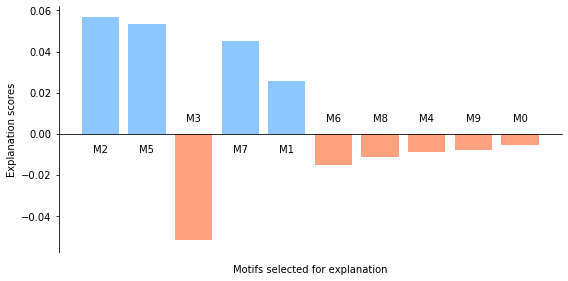

In [23]:
graph_index = 22
q = dict(zip(range(10),shaps10_exact[:,graph_index]))
plot_graphshap_scores(q,'M',is_local=True)
plt.tight_layout()
plt.savefig(PLOT_FOLDER+'fig7.pdf')

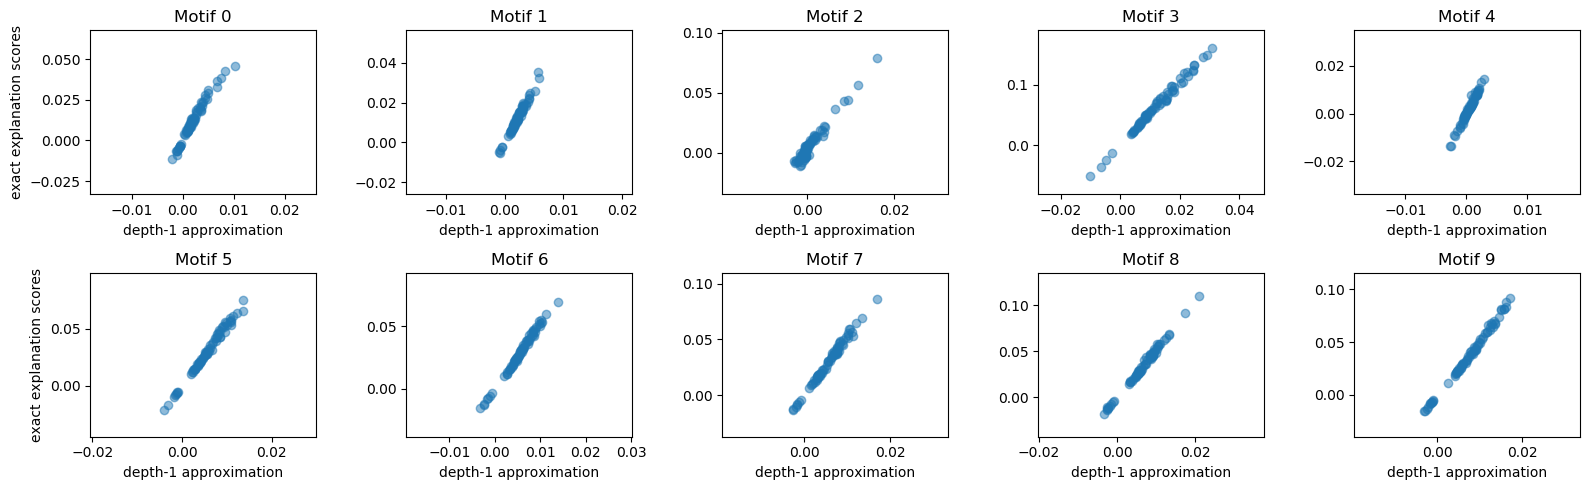

In [24]:
plt.figure(figsize=(16,5))
for m in range(10):
    plt.subplot(2,5,m+1)
    plt.scatter(shaps10_approx[m,:],shaps10_exact[m,:],alpha=.5)
    plt.title('Motif '+str(m))
    plt.xlabel('depth-1 approximation')
plt.subplot(2,5,1)
plt.ylabel('exact explanation scores')
plt.subplot(2,5,6)
plt.ylabel('exact explanation scores')
plt.tight_layout();
plt.savefig(PLOT_FOLDER+'fig8.pdf')

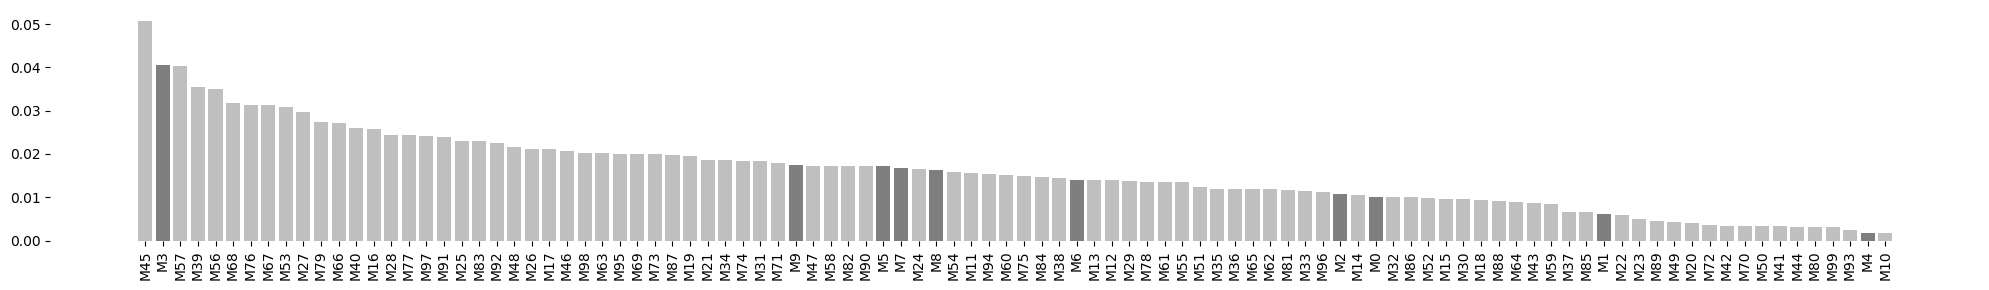

In [25]:
plt.figure(figsize=(20,3))
cols = ['black' if i<10 else 'gray' for i in np.argsort(shaps100_global)[::-1]]
plt.bar(range(100),sorted(shaps100_global/100)[::-1],color=cols,alpha=.5)
plt.xticks(range(100),['M'+str(i) for i in np.argsort(shaps100_global)[::-1]],rotation=90)
plt.tight_layout()
plt.box(False)
top_motifs = np.argsort(shaps100_global)[::-1][:5]
plt.savefig(PLOT_FOLDER+'fig9a.pdf')

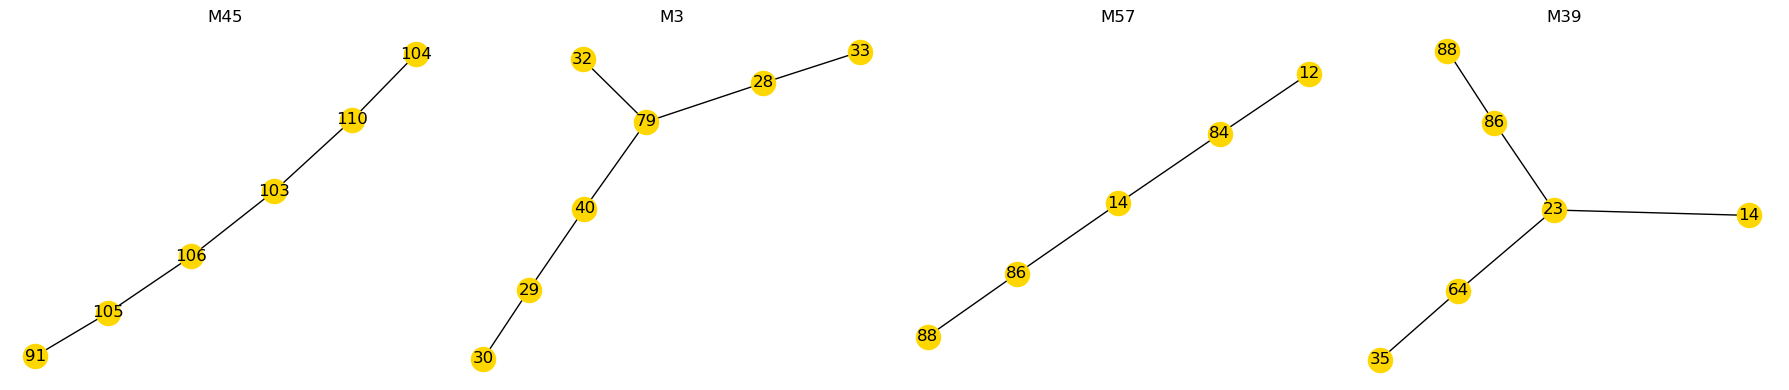

In [26]:
plt.figure(figsize=(18,4))
for indx in range(4):
    plt.subplot(1,4,indx+1)
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    M_ind = top_motifs[indx]
    nx.draw_networkx(motifs100[M_ind],node_color='gold')
    plt.title('M'+str(M_ind))
plt.tight_layout()
plt.savefig(PLOT_FOLDER+'fig9b.pdf')

In [27]:
def brainplot_motif(motif,brain_coord):
    adj = np.zeros((116,116))
    for a,b in motif.edges:
        adj[a,b] = 1
        adj[b,a] = 1
    plot_connectome(adj,brain_coord,display_mode='lyrz',node_kwargs={'alpha':.25},
            node_size = 10, edge_kwargs={'linewidth':2,'color':'b'});

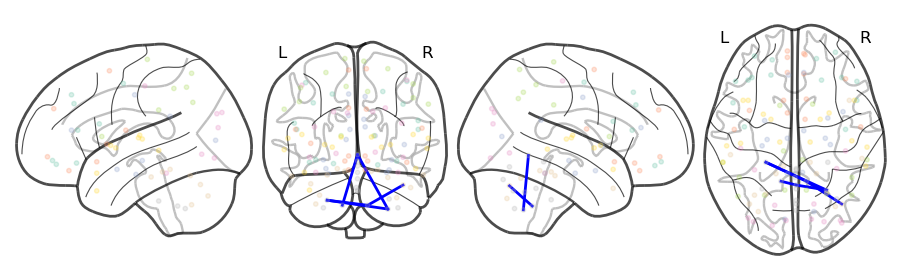

In [28]:
graph_index = top_motifs[0]
brainplot_motif(motifs100[graph_index],brain_coord.values[:,-3:])
plt.savefig(PLOT_FOLDER+'motif_A.pdf')

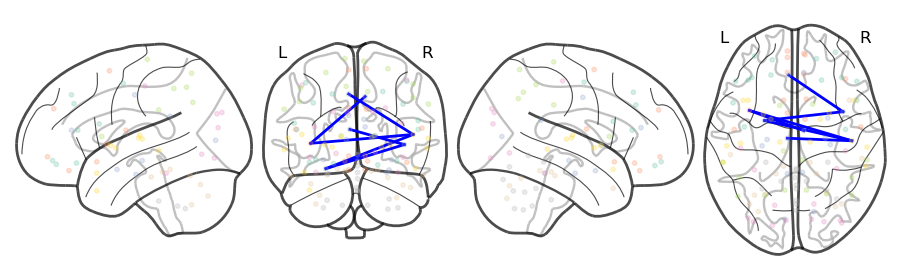

In [29]:
graph_index = top_motifs[1]
brainplot_motif(motifs100[graph_index],brain_coord.values[:,-3:])
plt.savefig(PLOT_FOLDER+'motif_B.pdf')

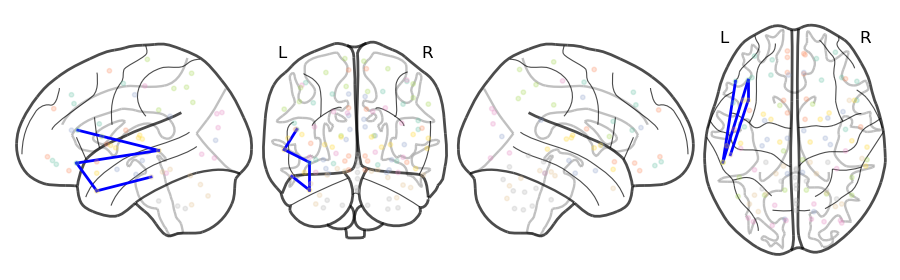

In [30]:
graph_index = top_motifs[2]
brainplot_motif(motifs100[graph_index],brain_coord.values[:,-3:])
plt.savefig(PLOT_FOLDER+'motif_C.pdf')

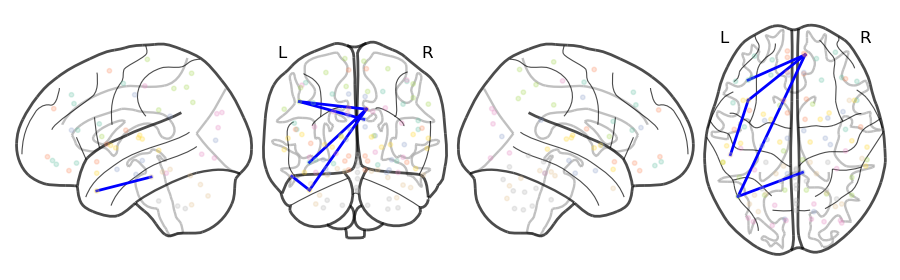

In [31]:
graph_index = top_motifs[3]
brainplot_motif(motifs100[graph_index],brain_coord.values[:,-3:])
plt.savefig(PLOT_FOLDER+'motif_D.pdf')